# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [21]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib

from math import sqrt, log2
from scipy import stats
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [2]:
CANCER_DATA_PATH = '../HW_2/data/cancer.csv'
SPAM_DATA_PATH = '../HW_2/data/spam.csv'

In [3]:
def read_cancer_dataset(path_to_csv):
    '''
    Возвращает пару из X и y. 
    X - массив векторов. 
    y - соответствующие векторам метки
    '''
    data = pd.read_csv(path_to_csv)
    X = data.drop('label', axis=1)
    y = (data['label'] == 'M').astype(np.int32)
    
    return X, y

def read_spam_dataset(path_to_csv):
    '''
    Возвращает пару из X и y. 
    X - массив векторов. 
    y - соответствующие векторам метки
    '''
    data = pd.read_csv(path_to_csv)
    X = data.drop('label', axis=1)
    y = data['label']
    
    return X, y

In [4]:
X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
X_spam, y_spam = read_spam_dataset(SPAM_DATA_PATH)

### Задание 1 (1 балл)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [5]:
def gini(x):
    size = x.size
    probabilities = np.unique(x, return_counts=True)[1] / size
    return (probabilities * (1 - probabilities)).sum()
    
    
def entropy(x):
    size = x.size
    probabilities = np.unique(x, return_counts=True)[1] / size
    return -(probabilities * np.log2(probabilities)).sum()
    
    
def gain(left_y, right_y, criterion):
    node = np.concatenate((left_y, right_y), axis=None)
    left_scale = left_y.size / node.size
    right_scale = right_y.size / node.size
    return criterion(node) - left_scale*criterion(left_y) - right_scale*criterion(right_y)

In [6]:
# Векторные аналоги реализованных выше алгоритмов, дающие ускорение в ~40 раз

def gini_vec(probs):
    gini_ind = 0
    for p in probs:
        gini_ind += p * (1 - p)
    return gini_ind
    
    
def entropy_vec(probs):
    entrpy = 0
    for p in probs:
        entrpy -= p * log2(p) if p > 0 else 0
    return entrpy
    
    
def gain_vec(vector, criterion):
    classes, counts = np.unique(vector, return_counts=True)
    classes = {x: i for i, x in enumerate(np.unique(vector))}
    n = vector.size
    counts_left = np.zeros_like(counts)
    counts_right = counts.copy()
    counts_left[classes[vector[0]]] = 1
    counts_right[classes[vector[0]]] -= 1
    
    vect_gain = np.ones(n) * n*criterion(counts/n)
    vect_gain[0] = 0
    for i in range(1, n):
        vect_gain[i] -= i*criterion(counts_left/i) + (n - i)*criterion(counts_right/(n - i))
        counts_left[classes[vector[i]]] += 1
        counts_right[classes[vector[i]]] -= 1
        
    return vect_gain / n


# Векторный вариант функции для случая двух классов {0,1}. Допускает установку шага дискретизации.
# Note: выигрыш по скорости работы перед gain_vec достигается при значениях step > 5
def gain_vec_bin(vector, criterion, step):
    n = vector.size
    sum_left = vector[:step].sum()
    sum_right = vector[step:].sum()
    sum_total = vector.sum()
    counts_total = np.array([n - sum_total, sum_total])
    counts_left = np.zeros_like(counts_total)
    counts_right = counts_total.copy()
    
    vect_gain = np.zeros(n)
    vect_gain[step:n:step] = n*criterion(counts_total/n)
    for i in range(step, n, step):
        sum_step = vector[i-step: i].sum()
        counts_step = step - sum_step, sum_step
        counts_left += counts_step
        counts_right -= counts_step
        vect_gain[i] -= i*criterion(counts_left/i) + (n - i)*criterion(counts_right/(n - i))
        
    return vect_gain / n

CPU times: user 16.5 ms, sys: 4.04 ms, total: 20.6 ms
Wall time: 15.3 ms
CPU times: user 3.96 ms, sys: 0 ns, total: 3.96 ms
Wall time: 3.97 ms


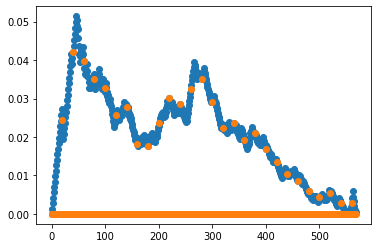

In [8]:
%time gain_y = gain_vec(y_cancer, gini_vec)
plt.scatter(np.arange(gain_y.size), gain_y)
%time gain_y = gain_vec_bin(y_cancer, gini_vec, 20)
plt.scatter(np.arange(gain_y.size), gain_y)
plt.show()

### Задание 2 (1 балл)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбиваем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__ (например, для вычисления вероятности в следующем задании)

In [9]:
class DecisionTreeLeaf:
    def __init__(self, y, classes):
        self.y = stats.mode(y)[0][0]
        self.probs = {}
        size = y.size
        for cls in classes:
            self.probs[cls] = (y == cls).sum() / size
            

class DecisionTreeNode:
    def __init__(self, split_dim, split_value, left, right):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right

### Задание 3 (6 баллов)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`. Вероятности классов в листе можно определить через количество объектов соответствующего класса в листе. 

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [213]:
class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1, pre_prune=False):
        CRITERIONS = {
            'gini': gini_vec,
            'entropy': entropy_vec,
        }
        self.root = None
        self.criterion = CRITERIONS[criterion]
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.pre_prune = pre_prune
        
        
    def fit(self, X, y):
        self.classes, counts = np.unique(y, return_counts=True)
        self.major_class = self.classes[counts.argmax()]
        self.root = self._tree_construct(X, y)
        
    
    def predict_proba(self, X):
        prediction = pd.Series(pd.NA, index=X.index)
        for i, x in X.iterrows():
            prediction[i] = self.predict_proba_scalar(x)
        return prediction
    
        
    def predict_proba_scalar(self, x):
        node = self.root
        while not isinstance(node, DecisionTreeLeaf):
            split_dim, split_value = node.split_dim, node.split_value
            if x[split_dim] < split_value:
                node = node.left
            else:
                node = node.right

        return node.probs
        
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]
    
    
    def _best_split(self, X, y, max_steps=None):   
        divisors = {}
        for dim in X.columns:
            argsort_x = X.index[np.argsort(X[dim])]
            values, x_unique = np.unique(np.sort(X[dim]), return_index=True)
            
            if max_steps and y.size//max_steps >= 5:
                step = y.size//max_steps
                inform_gain = -gain_vec_bin(y[argsort_x].values, self.criterion, step)
            else:
                inform_gain = -gain_vec(y[argsort_x].values, self.criterion)
                
            inform_gain[x_unique] *= -1
            max_purity_id = np.argmax(inform_gain)
            divisors[dim] = (X[dim][argsort_x[max_purity_id]], inform_gain[max_purity_id])

        split_dim, (split_value, max_purity) = max(divisors.items(), key=lambda x: x[1][1])
        return split_dim, split_value
    
    
    def _tree_construct(self, X, y, lvl=0):

        def bernulli_distinct_test(sample1, sample2):
            n1, n2 = sample1.size, sample2.size
            k1, k2 = sample1.sum(), sample2.sum()
            p1, p2, p = k1/n1, k2/n2, (k1+k2)/(n1+n2)
            z = abs(p1 - p2) / sqrt(p * (1 - p) * (1/n1 + 1/n2))
            return z > 1.96

        if y.unique().size == 1 or (self.max_depth and lvl == self.max_depth):
            return DecisionTreeLeaf(y, self.classes)

        split_dim, split_value = self._best_split(X, y)
        split_indices = X[split_dim] < split_value
        X_left, y_left = X[split_indices], y[split_indices]
        X_right, y_right = X[-split_indices], y[-split_indices]
        
        leaf_size_constraint = min(y_left.size, y_right.size) < self.min_samples_leaf
        pre_prune_constraint = not bernulli_distinct_test(y_left, y_right) \
                                                if self.pre_prune else False
        if leaf_size_constraint or pre_prune_constraint:
            return DecisionTreeLeaf(y, self.classes)

        node = DecisionTreeNode(
            split_dim,
            split_value,
            self._tree_construct(X_left, y_left, lvl=lvl+1),
            self._tree_construct(X_right, y_right, lvl=lvl+1),
        )
        return node

In [203]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_cancer, y_cancer)

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [11]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%s] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

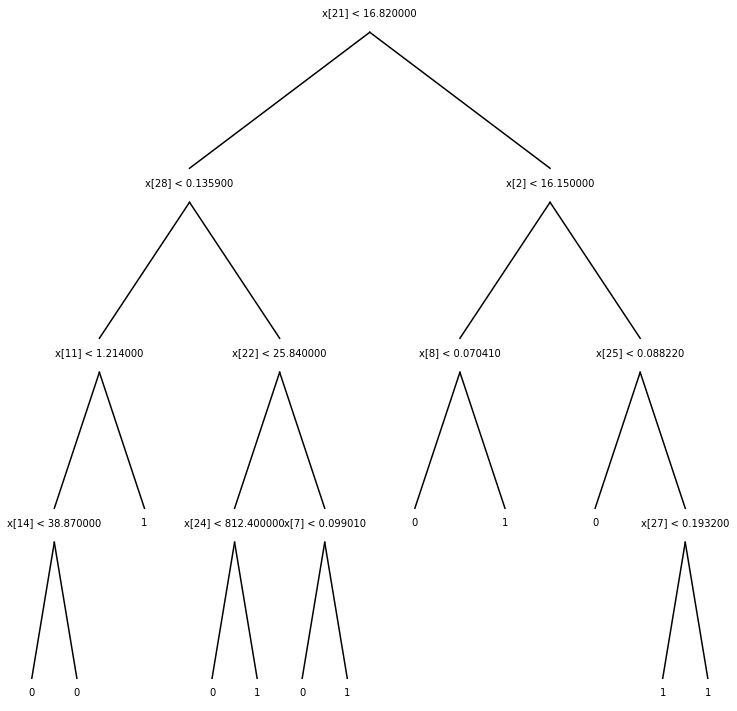

In [14]:
draw_tree(tree, '1.png')

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [147]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        if isinstance(list(p_pred)[0], dict):
            y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        else:
            y_pred = [(0 if p[0] > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [83]:
def train_test_split(X, y, ratio=0.9):
    '''
    Возвращает X_train, y_train, X_test, y_test
    X_train и X_test - массив векторов - две части массива X, 
    разделенного в состветсви с коэффициентом ratio.
    y_train и y_test - соответствующие X_train и X_test метки классов
    '''
    
    test_size = int(X.shape[0] * (1-ratio))
    test_indexes = np.random.choice(X.index,
                                    size=test_size,
                                    replace=False)
    X_train = X.drop(test_indexes)
    y_train = y.drop(test_indexes)
    
    X_test = X.loc[test_indexes]
    y_test = y.loc[test_indexes]
    
    return X_train, y_train, X_test, y_test

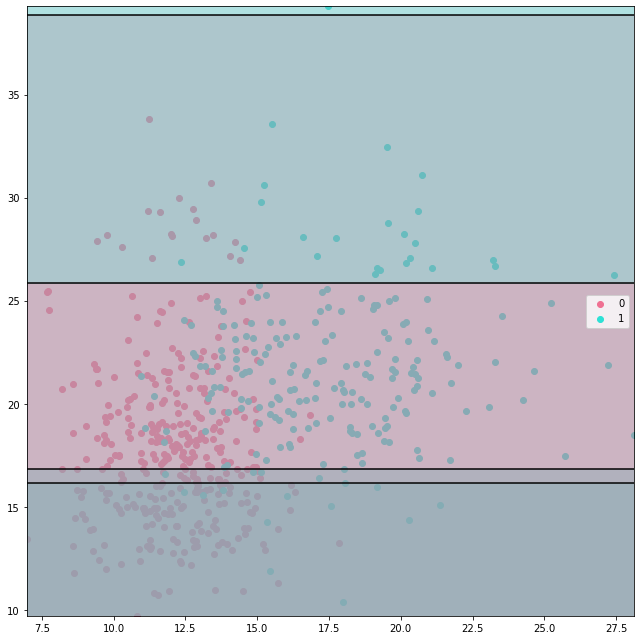

In [20]:
plot_2d(tree, np.array(X_cancer), np.array(y_cancer))

Я так и не понял, что означает эта визуализация(

Сделаю свою как в лекции, чтобы было нагляднее!

In [37]:
def plot_2d(tree, X, y):
    
    class Bounds:
        def __init__(self, l, r, b, t, x_dim, y_dim):
            self.l = l
            self.r = r
            self.b = b
            self.t = t
            self.x_dim = x_dim
            self.y_dim = y_dim

        def split_by_dim(self, x, dim):
            l, r, b, t = self.l, self.r, self.b, self.t
            x_dim, y_dim = self.x_dim, self.y_dim
            if dim == x_dim:
                bounds_1 = Bounds(l, x, b, t, x_dim, y_dim)
                bounds_2 = Bounds(x, r, b, t, x_dim, y_dim)
            elif dim == y_dim:
                bounds_1 = Bounds(l, r, b, x, x_dim, y_dim)
                bounds_2 = Bounds(l, r, x, t, x_dim, y_dim)
            return bounds_1, bounds_2

        def get_rectangle(self):
            l, r, b, t = self.l, self.r, self.b, self.t
            return Rectangle((l, b), r-l, t-b)
    
    def tree_descent(node, bounds, collections):
        if isinstance(node, DecisionTreeNode):
            bounds_1, bounds_2 = bounds.split_by_dim(node.split_value, node.split_dim)
            tree_descent(node.left, bounds_1, collections)
            tree_descent(node.right, bounds_2, collections)
        elif isinstance(node, DecisionTreeLeaf):
            collections[node.y].append(bounds.get_rectangle())
    
    assert X.shape[1] == 2
    collections = {cls: [] for cls in np.unique(y)}
    
    (l, r), (b, t) = zip(X.min(axis=0), X.max(axis=0))
    x_dim, y_dim = X.columns
    bounds = Bounds(l, r, b, t, x_dim, y_dim)
    tree_descent(tree.root, bounds, collections)
    
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.set_xlim(l, r)
    ax.set_ylim(b, t)
    ax.set_xlabel(x_dim)
    ax.set_ylabel(y_dim)
    
    colors = ['y', 'b']
    for cls in collections:
        pc = PatchCollection(
            collections[cls],
            facecolor=colors[cls],
            edgecolor='None',
            alpha=0.4,
        )
        ax.add_collection(pc)
        ax.scatter(
            X[x_dim][y == cls],
            X[y_dim][y == cls],
            c=colors[cls]
        )
        
    plt.show()

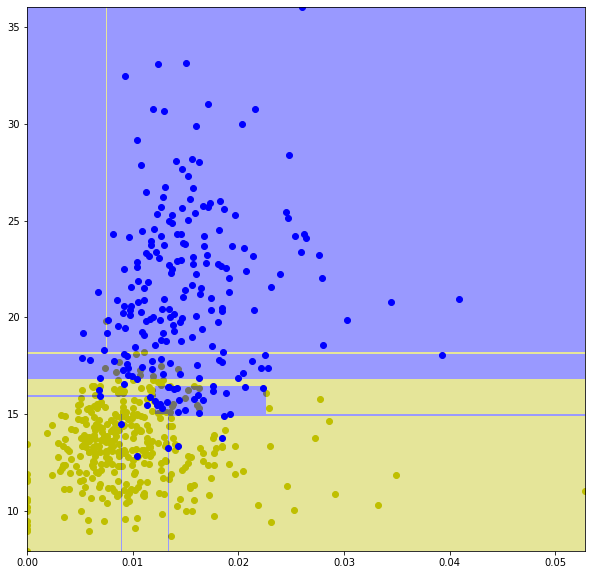

In [36]:
dims = np.random.choice(X_cancer.columns, size=2, replace=False)
                        
tree_2d = DecisionTreeClassifier(max_depth=5)
tree_2d.fit(X_cancer[dims], y_cancer)

plot_2d(tree_2d, X_cancer[dims], y_cancer)

Знаю, что дерево переобучено, но это сделано для наглядности)

## Задание 4 (2 балла)

Протестируйте решение на данных cancer и spam (датасеты из директории `hw2_data`).
Выполните загрузку и предобработку данных.


Если необходимо, попробуйте разные наборы параметров для получения лучшего результата.

Посчитайте метрики `precision`, `recall`, `accuracy` для модели дерева.
Сравните значения метрик с результатами модели kNN из предыдущего задания (можно использовать реализацию из библиотеки `sklearn`). 

Какой нужен препроцессинг данных для моделей?
Какая модель делает предсказания лучше?  Предположите, почему.

_Ваш ответ_

In [117]:
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, \
                            recall_score, precision_score

from sklearn.neighbors import KNeighborsClassifier

### Cancer

Decision Tree Classifier


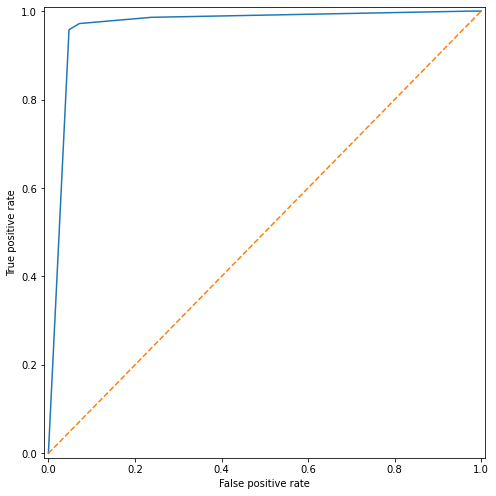

K Neighbors Classifier


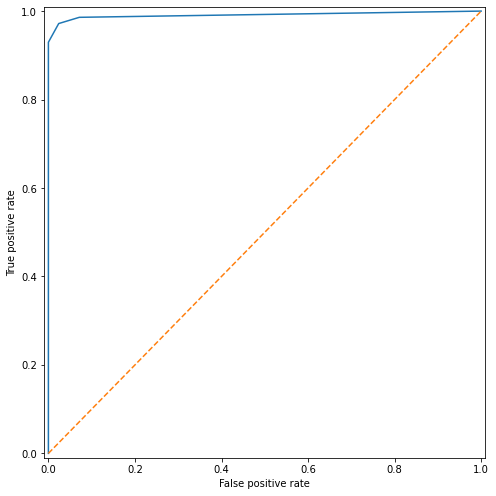

In [222]:
X_train, y_train, X_test, y_test = train_test_split(X_cancer, y_cancer, 0.8)

print('Decision Tree Classifier')
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)
tree.fit(X_train, y_train)
tree_predict_proba = tree.predict_proba(X_test)
tree_predict = tree.predict(X_test)

plot_roc_curve(y_test, tree_predict_proba)


print('K Neighbors Classifier')
min_max_scaler = preprocessing.MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.fit_transform(X_test)

knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train_scaled, y_train)
knn_predict_proba = knn_classifier.predict_proba(X_test_scaled)
knn_predict = knn_classifier.predict(X_test_scaled)

plot_roc_curve(y_test, knn_predict_proba)

In [175]:
print('\t\t|  tree   │   knn   │')
print('────────────────┼─────────┼─────────┤')
for score in [accuracy_score, recall_score, precision_score]:
    print(f'{score.__name__}\t│  {score(y_test, tree_predict):.3f}  │', end='')
    print(f'  {score(y_test, knn_predict):.3f}  │')

		|  tree   │   knn   │
────────────────┼─────────┼─────────┤
accuracy_score	│  0.947  │  0.973  │
recall_score	│  0.897  │  0.923  │
precision_score	│  0.946  │  1.000  │


### Spam

Decision Tree Classifier


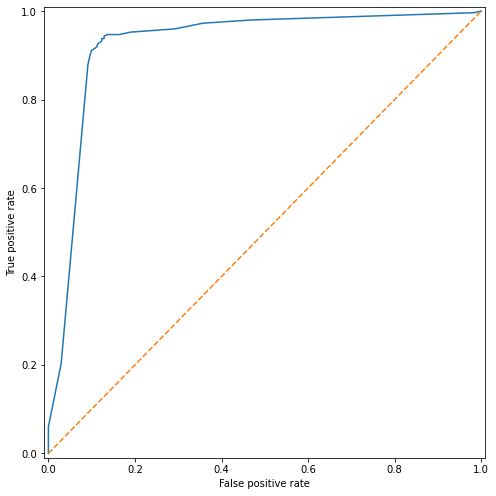

K Neighbors Classifier


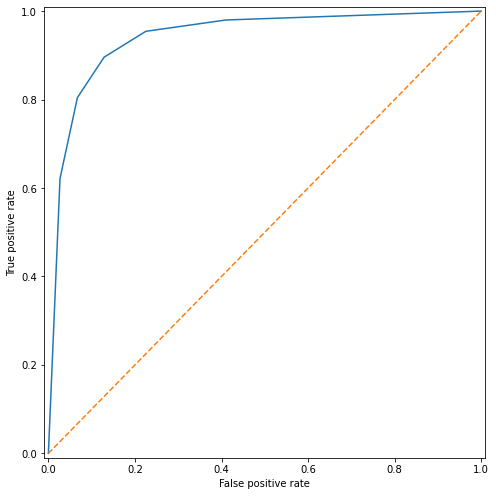

In [226]:
X_train, y_train, X_test, y_test = train_test_split(X_spam, y_spam, 0.8)

print('Decision Tree Classifier')
tree = DecisionTreeClassifier(max_depth=15, min_samples_leaf=5)
tree.fit(X_train, y_train)
tree_predict_proba = tree.predict_proba(X_test)
tree_predict = tree.predict(X_test)

plot_roc_curve(y_test, tree_predict_proba)


print('K Neighbors Classifier')
min_max_scaler = preprocessing.MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.fit_transform(X_test)

knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train_scaled, y_train)
knn_predict_proba = knn_classifier.predict_proba(X_test_scaled)
knn_predict = knn_classifier.predict(X_test_scaled)

plot_roc_curve(y_test, knn_predict_proba)

In [227]:
print('\t\t|  tree   │   knn   │')
print('────────────────┼─────────┼─────────┤')
for score in [accuracy_score, recall_score, precision_score]:
    print(f'{score.__name__}\t│  {score(y_test, tree_predict):.3f}  │', end='')
    print(f'  {score(y_test, knn_predict):.3f}  │')

		|  tree   │   knn   │
────────────────┼─────────┼─────────┤
accuracy_score	│  0.911  │  0.886  │
recall_score	│  0.877  │  0.871  │
precision_score	│  0.901  │  0.851  │


Данные из датасета __Spam__ куда менее линейны и дерево разделяет их лучше чем knn, чего нельзя сказать о первом датасете.